### Data Generation

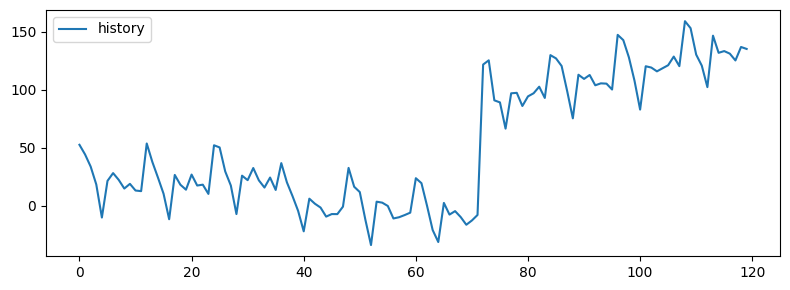

In [1]:
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

def trend(time):
    slope = np.zeros_like(a=time)
    slope[time < (3*12)] = 0.2
    slope[(time >= (3*12)) & (time < (6*12))] = -0.4
    slope[time >= (6*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5):
    rnd = np.random.RandomState(seed=42)
    return rnd.randn(len(time)) * noise_level

period = 12; baseline = 10; amplitude = 40

time_history = np.arange(10*12, dtype=np.float32)
ts_history = baseline + trend(time=time_history)\
    + seasonality(time=time_history, period=period, amplitude=amplitude)\
    + noise(time=time_history)
ts_history = ts_history.astype(np.float32)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Dataset & DataLoader

In [2]:
from sklearn import preprocessing
import torch

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
ts_scaled = scaler.fit_transform(X=ts_history.reshape(-1, 1)).flatten()
src_len = 24; tgt_len = 1
ts_train = ts_scaled[:-12]; ts_test = ts_scaled[-(src_len+12):]

class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, ts, src_len, tgt_len):
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32).view(-1, 1)
        self.src_len = src_len; self.tgt_len = tgt_len
        self.idxs = list(range(len(ts) - (src_len + tgt_len) + 1))

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        i = self.idxs[idx]
        src = self.ts[i : i + self.src_len]
        tgt = self.ts[i + self.src_len : i + self.src_len + self.tgt_len]
        return src, tgt

torch.manual_seed(seed=42)
dl_train = torch.utils.data.DataLoader(batch_size=8, shuffle=True,
    dataset=TrainingDataset(ts=ts_train, src_len=src_len, tgt_len=tgt_len))
dl_test = torch.utils.data.DataLoader(batch_size=8, shuffle=False,
    dataset=TrainingDataset(ts=ts_test, src_len=src_len, tgt_len=tgt_len))

src, tgt = next(iter(dl_test))
print(src.shape, tgt.shape)

torch.Size([8, 24, 1]) torch.Size([8, 1, 1])


### Multi-head Attention

In [28]:
import numpy as np
import torch

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, nheads):
        super().__init__()
        assert d_model % nheads == 0

        self.d_model = d_model
        self.nheads = nheads
        self.d_k = d_model // nheads

        self.W_q = torch.nn.Linear(in_features=d_model, out_features=d_model)
        self.W_k = torch.nn.Linear(in_features=d_model, out_features=d_model)
        self.W_v = torch.nn.Linear(in_features=d_model, out_features=d_model)
        self.W_o = torch.nn.Linear(in_features=d_model, out_features=d_model)

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        output = x.view(batch_size, seq_length, self.nheads, self.d_k)\
            .transpose(dim0=1, dim1=2)
        return output

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(dim0=-2, dim1=-1)) / np.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill_(mask == 0, value=-1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        output = x.transpose(dim0=1, dim1=2).contiguous()\
            .view(batch_size, seq_length, self.d_model)
        return output

    def forward(self, Q, K, V, mask):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

### Point-wise Feed-forward Networks

In [29]:
import torch

class PositionWiseFeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=d_model, out_features=d_ff)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(in_features=d_ff, out_features=d_model)

    def forward(self, x):
        output = self.fc2(self.relu(self.fc1(x)))
        return output

### Positional Encoding

In [30]:
import numpy as np
import torch

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        pe = torch.zeros(size=(max_seq_length, d_model))
        position = torch.arange(end=max_seq_length, dtype=torch.float32).unsqueeze(dim=1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            *(-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(dim=0))

    def forward(self, x):
        output = x + self.pe[:, :x.size(1)]
        return output

### Encoder Blocks

In [31]:
import torch

class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, nheads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model=d_model, nheads=nheads)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.norm1 = torch.nn.LayerNorm(normalized_shape=d_model)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff=d_ff)
        self.norm2 = torch.nn.LayerNorm(normalized_shape=d_model)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        output = self.norm2(x + self.dropout(ff_output))
        return output

### Decoder Blocks

In [33]:
import torch

class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, nheads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model=d_model, nheads=nheads)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.norm1 = torch.nn.LayerNorm(normalized_shape=d_model)
        self.cross_attn = MultiHeadAttention(d_model=d_model, nheads=nheads)
        self.norm2 = torch.nn.LayerNorm(normalized_shape=d_model)
        self.feed_forward = PositionWiseFeedForward(d_model=d_model, d_ff=d_ff)
        self.norm3 = torch.nn.LayerNorm(normalized_shape=d_model)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        output = self.norm3(x + self.dropout(ff_output))
        return output

### Transformer

In [53]:
import torch

class Transformer(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def generate_mask(self, src, tgt):
        src_mask = (src != 0)
        tgt_mask = (tgt != 0)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(size=(1, seq_length, seq_length)),
            diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src=src, tgt=tgt)
        src_emb = self.encoder_embedding(src)
        print(src_mask, tgt_mask)

model = Transformer()
src = torch.tensor(data=[0, 1, 0, 2], dtype=torch.long).view(1, 4, 1)
model(src=src, tgt=src)


tensor([[[False],
         [ True],
         [False],
         [ True]]]) tensor([[[False, False, False, False],
         [ True,  True, False, False],
         [False, False, False, False],
         [ True,  True,  True,  True]]])


In [ ]:
import numpy as np
import torch

class TransformerForecast(torch.nn.Module):
    def __init__(self, num_features=1, d_model=128):
        super().__init__()

        self.enc_emb = torch.nn.Linear(in_features=num_features,
            out_features=d_model)
        self.dec_emb = torch.nn.Linear(in_features=num_features,
            out_features=d_model)
        self.positional = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=4,
            batch_first=True, num_encoder_layers=2, num_decoder_layers=2)

        self.output_proj = torch.nn.Linear(in_features=d_model,
            out_features=num_features)

    def forward(self, src, tgt):
        src = self.enc_emb(src)
        src = self.positional(src)

        tgt = self.dec_emb(tgt)
        tgt = self.positional(tgt)
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.size(1)).to(tgt.device)

        out = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        return self.output_proj(out)

    def infer(self, src, tgt_len):
        decoder_input = src[:, -1:].clone()
        predictions = []
        for _ in range(tgt_len):
            output = self.forward(src=src, tgt=decoder_input)
            next_prediction = output[:, -1:]
            predictions.append(next_prediction)
            decoder_input = torch.cat((decoder_input, next_prediction), dim=1)
        return torch.cat(predictions, dim=1)

torch.manual_seed(seed=42)
model = TransformerForecast()

total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

src, tgt = next(iter(dl_test))
out = model(src=src, tgt=tgt)
print(tgt.shape, out.shape)

In [ ]:
import torch
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl_train, criterion, optimizer, device):
    model.train()
    losses = []
    for batch in dl_train:
        src, tgt = [x.to(device) for x in batch]
        tgt_in = torch.cat(tensors=[src[:, -1:], tgt[:, :-1]], dim=1)
        out = model(src=src, tgt=tgt_in)

        loss = criterion(input=out, target=tgt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl_test, criterion, device):
    model.eval()
    losses = []
    for batch in dl_test:
        src, tgt = [x.to(device) for x in batch]
        # tgt_in = torch.cat(tensors=[src[:, -1:], tgt[:, :-1]], dim=1)
        out = model.infer(src=src, tgt_len=tgt.shape[1])

        loss = criterion(input=out, target=tgt)
        losses.append(loss.item())
    return np.mean(losses)

def training(model, dl_train, dl_test, model_path, max_epochs, device):
    model = model.to(device)
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
        mode='min', factor=0.9, patience=5)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    for epoch in range(max_epochs):
        train_loss = train_step(model=model, dl_train=dl_train,
            criterion=criterion, optimizer=optimizer, device=device)
        history['train_loss'].append(train_loss)
        test_loss = test_step(model=model, dl_test=dl_test,
            criterion=criterion, device=device)
        history['test_loss'].append(test_loss)
        scheduler.step(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(obj=model.state_dict(), f=model_path)

    return history

torch.manual_seed(seed=42)
model = TransformerForecast()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs('models', exist_ok=True)
model_path = 'models/best_model.pth'

start_time = time.time()
history = training(model=model, dl_train=dl_train, dl_test=dl_test,
    model_path=model_path, max_epochs=100, device=device)
print("Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='test_loss', label='test')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss (log scale)')
    plt.tight_layout()
    plt.show()

plot_history(history=history)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecast().to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

len_idx = len(ts_scaled) - (src_len + tgt_len) + 1
idx = np.arange(stop=len_idx).reshape(-1, 1) + np.arange(stop=src_len)
src = torch.tensor(data=ts_scaled[idx], dtype=torch.float32)\
    .unsqueeze(dim=-1).to(device)

# idx = np.arange(stop=len_idx).reshape(-1, 1) + np.arange(start=src_len,
#     stop=src_len+tgt_len) - 1
# tgt_in = torch.tensor(data=ts_scaled[idx-1], dtype=torch.float32)\
#     .unsqueeze(dim=-1).to(device)

model.eval()
with torch.no_grad():
    out = model.infer(src=src, tgt_len=tgt_len)
ts_pred = out.squeeze()
ts_pred = scaler.inverse_transform(X=out.reshape(-1, 1)).flatten()
time_pred = time_history[-len(ts_pred):]


# steps = 60
# time_future = np.arange(start=len(ts_history), stop=len(ts_history)+steps, dtype=np.float32)
# ts_future = forecast(model=model, ts=ts_history, src_len=src_len, steps=steps)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=time_pred, y=ts_pred, label='forecast', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()